In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = True
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-29 10:04:52.257470: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-07-29 10:05:04.928140: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-07-29 10:05:04.960541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-07-29 10:05:04.960578: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-07-29 10:05:04.962829: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-07-29 10:05:04.965117: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load data from the output of Brusselator model

In [5]:
data_path = os.path.abspath("../turing_Brusselator.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("../turing_t_Brusselator.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
# Thining the dataset
t_star = t_star[::4]
data = data[..., ::4]

T = t_star.shape[0]    
    
L = 1.0
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']


In [7]:
data.shape

(2, 32, 32, 64)

# Run Koch-Meinhardt's ASDM model with given diffusion constants and correct space-time scalse to find other parameters

In [8]:
layers = [3, 64, 64, 64, 64, 2]

pinn = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss = ASDM(dtype=tf.float64, init_value=1.0)
pde_non_zero = Non_zero_params("ASDM", parameters=[pde_loss.D_u, pde_loss.D_v], print_precision=".8f")

In [9]:
model = tu.TINN(pinn, 
                pde_loss, 
                extra_loss=[pde_non_zero], 
                optimizer=keras.optimizers.Adam(learning_rate=0.01), 
                alpha = 0.5)

In [10]:
results = model.train(epochs=10000,
                      batch_size=len(obs_X)//5,
                      X=obs_X,
                      Y=obs_Y,
                      print_interval=50,
                      stop_threshold=1e-5,
                      shuffle=True,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0


2022-07-29 10:06:44.718833: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-29 10:06:58.014142: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 18.42805
total loss: 38.91375, total regularisd loss (sum of batches): 198.22924
obs u loss: 31.97252, obs v loss: 4.88359
pde u loss: 1.26884, pde v loss: 0.78880
lambda obs u: 1.00000, lambda obs v: 1.00000
lambda pde u: 1.00000, lambda pde v: 1.00000
D_u: 0.96415 D_v: 0.96168 sigma_u: 0.94701 sigma_v: 0.95688 
mu_u: 0.96890 rho_u: 0.95936 rho_v: 0.98096 kappa_u: 1.03464 

extra loss non_zero_ASDM: 0.00000
Time taken: 36.90s

Start of epoch 50
Training observations acc over epoch: 8.75737
total loss: 17.58968, total regularisd loss (sum of batches): 361.72202
obs u loss: 16.59995, obs v loss: 0.91479
pde u loss: 0.06431, pde v loss: 0.01063
lambda obs u: 3.95830, lambda obs v: 0.02663
lambda pde u: 0.01048, lambda pde v: 0.00459
D_u: 0.61522 D_v: 0.79391 sigma_u: 1.09165 sigma_v: 1.16273 
mu_u: 0.75595 rho_u: 1.15591 rho_v: 0.74452 kappa_u: 1.16663 

extra loss non_zero_ASDM: 0.00000
Time taken: 32.27s

Start of epoch 100
Training observations ac


Start of epoch 850
Training observations acc over epoch: 8.60603
total loss: 17.38566, total regularisd loss (sum of batches): 425.64478
obs u loss: 16.70582, obs v loss: 0.50623
pde u loss: 0.15005, pde v loss: 0.02355
lambda obs u: 3.97865, lambda obs v: 0.01879
lambda pde u: 0.00241, lambda pde v: 0.00015
D_u: 0.05522 D_v: 0.21695 sigma_u: 0.80125 sigma_v: 1.18539 
mu_u: 0.47123 rho_u: 0.81560 rho_v: 0.65866 kappa_u: 1.45597 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.64s

Start of epoch 900
Training observations acc over epoch: 8.33407
total loss: 16.80877, total regularisd loss (sum of batches): 391.23551
obs u loss: 16.14545, obs v loss: 0.52269
pde u loss: 0.11150, pde v loss: 0.02913
lambda obs u: 3.98119, lambda obs v: 0.01791
lambda pde u: 0.00075, lambda pde v: 0.00016
D_u: 0.05578 D_v: 0.21702 sigma_u: 0.78034 sigma_v: 1.18492 
mu_u: 0.49004 rho_u: 0.79409 rho_v: 0.65897 kappa_u: 1.46640 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.64s

Start of epoch 950
Trai


Start of epoch 1700
Training observations acc over epoch: 8.30257
total loss: 16.65229, total regularisd loss (sum of batches): 334.89472
obs u loss: 16.08727, obs v loss: 0.51788
pde u loss: 0.02877, pde v loss: 0.01837
lambda obs u: 3.98463, lambda obs v: 0.01525
lambda pde u: 0.00008, lambda pde v: 0.00004
D_u: 0.08155 D_v: 0.22161 sigma_u: 0.33176 sigma_v: 1.09973 
mu_u: 0.19777 rho_u: 0.31081 rho_v: 0.69671 kappa_u: 1.64461 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.60s

Start of epoch 1750
Training observations acc over epoch: 8.75876
total loss: 17.54497, total regularisd loss (sum of batches): 402.56366
obs u loss: 16.89150, obs v loss: 0.62602
pde u loss: 0.00718, pde v loss: 0.02027
lambda obs u: 3.97697, lambda obs v: 0.02264
lambda pde u: 0.00012, lambda pde v: 0.00027
D_u: 0.08472 D_v: 0.22241 sigma_u: 0.34216 sigma_v: 1.09724 
mu_u: 0.17523 rho_u: 0.31848 rho_v: 0.69604 kappa_u: 1.64338 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.60s

Start of epoch 1800
T


Start of epoch 2550
Training observations acc over epoch: 8.33166
total loss: 16.66425, total regularisd loss (sum of batches): 322.45068
obs u loss: 16.19481, obs v loss: 0.46851
pde u loss: 0.00087, pde v loss: 0.00007
lambda obs u: 3.97982, lambda obs v: 0.02018
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 0.17367 D_v: 0.25456 sigma_u: 0.17896 sigma_v: 0.92364 
mu_u: 0.08778 rho_u: 0.13945 rho_v: 0.62515 kappa_u: 1.71593 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.58s

Start of epoch 2600
Training observations acc over epoch: 8.33493
total loss: 16.67378, total regularisd loss (sum of batches): 368.21146
obs u loss: 16.19379, obs v loss: 0.47608
pde u loss: 0.00214, pde v loss: 0.00177
lambda obs u: 3.98345, lambda obs v: 0.01653
lambda pde u: 0.00000, lambda pde v: 0.00002
D_u: 0.18253 D_v: 0.26213 sigma_u: 0.18055 sigma_v: 0.92162 
mu_u: 0.08355 rho_u: 0.14104 rho_v: 0.62021 kappa_u: 1.71849 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.54s

Start of epoch 2650
T


Start of epoch 3400
Training observations acc over epoch: 8.36557
total loss: 16.73548, total regularisd loss (sum of batches): 329.16765
obs u loss: 16.17897, obs v loss: 0.55217
pde u loss: 0.00008, pde v loss: 0.00427
lambda obs u: 3.98674, lambda obs v: 0.01323
lambda pde u: 0.00000, lambda pde v: 0.00002
D_u: 0.40569 D_v: 0.50288 sigma_u: 0.09793 sigma_v: 0.47794 
mu_u: 0.03720 rho_u: 0.06113 rho_v: 0.33913 kappa_u: 1.85617 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.54s

Start of epoch 3450
Training observations acc over epoch: 8.41284
total loss: 16.82605, total regularisd loss (sum of batches): 346.14535
obs u loss: 16.35693, obs v loss: 0.46875
pde u loss: 0.00034, pde v loss: 0.00003
lambda obs u: 3.98087, lambda obs v: 0.01913
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 0.42648 D_v: 0.52727 sigma_u: 0.09285 sigma_v: 0.46505 
mu_u: 0.03905 rho_u: 0.05687 rho_v: 0.33871 kappa_u: 1.85657 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.51s

Start of epoch 3500
T


Start of epoch 4250
Training observations acc over epoch: 8.24440
total loss: 16.48883, total regularisd loss (sum of batches): 320.11103
obs u loss: 16.00901, obs v loss: 0.47979
pde u loss: 0.00001, pde v loss: 0.00002
lambda obs u: 3.98475, lambda obs v: 0.01525
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 0.94731 D_v: 1.15198 sigma_u: 0.05183 sigma_v: 0.17108 
mu_u: 0.01821 rho_u: 0.01969 rho_v: 0.12766 kappa_u: 1.92079 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.47s

Start of epoch 4300
Training observations acc over epoch: 8.71031
total loss: 17.42105, total regularisd loss (sum of batches): 488.83873
obs u loss: 16.94237, obs v loss: 0.47824
pde u loss: 0.00022, pde v loss: 0.00021
lambda obs u: 3.98173, lambda obs v: 0.01826
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 0.99552 D_v: 1.20998 sigma_u: 0.05169 sigma_v: 0.16991 
mu_u: 0.01756 rho_u: 0.01950 rho_v: 0.12339 kappa_u: 1.92131 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.44s

Start of epoch 4350
T


Start of epoch 5100
Training observations acc over epoch: 8.51101
total loss: 17.02211, total regularisd loss (sum of batches): 497.46299
obs u loss: 16.51227, obs v loss: 0.50975
pde u loss: 0.00002, pde v loss: 0.00006
lambda obs u: 3.97765, lambda obs v: 0.02235
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 2.15969 D_v: 2.57482 sigma_u: 0.03336 sigma_v: 0.09015 
mu_u: 0.00759 rho_u: 0.00207 rho_v: 0.06888 kappa_u: 1.92662 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.56s

Start of epoch 5150
Training observations acc over epoch: 8.25528
total loss: 16.51063, total regularisd loss (sum of batches): 318.99730
obs u loss: 16.00298, obs v loss: 0.50758
pde u loss: 0.00001, pde v loss: 0.00005
lambda obs u: 3.98865, lambda obs v: 0.01135
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 2.26079 D_v: 2.68817 sigma_u: 0.03303 sigma_v: 0.08751 
mu_u: 0.00702 rho_u: 0.00174 rho_v: 0.06675 kappa_u: 1.92674 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.55s

Start of epoch 5200
T


Start of epoch 5950
Training observations acc over epoch: 8.30765
total loss: 16.61536, total regularisd loss (sum of batches): 454.11773
obs u loss: 16.12084, obs v loss: 0.49446
pde u loss: 0.00001, pde v loss: 0.00005
lambda obs u: 3.98106, lambda obs v: 0.01894
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 4.16510 D_v: 4.62374 sigma_u: 0.02788 sigma_v: 0.06010 
mu_u: 0.00608 rho_u: 0.00005 rho_v: 0.04409 kappa_u: 1.92763 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.58s

Start of epoch 6000
Training observations acc over epoch: 8.31001
total loss: 16.62006, total regularisd loss (sum of batches): 327.63659
obs u loss: 16.03710, obs v loss: 0.58292
pde u loss: 0.00000, pde v loss: 0.00004
lambda obs u: 3.99073, lambda obs v: 0.00927
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 4.28500 D_v: 4.73544 sigma_u: 0.02758 sigma_v: 0.05888 
mu_u: 0.00572 rho_u: 0.00026 rho_v: 0.04377 kappa_u: 1.92764 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.56s

Start of epoch 6050
T


Start of epoch 6800
Training observations acc over epoch: 8.97011
total loss: 17.94030, total regularisd loss (sum of batches): 348.03416
obs u loss: 17.42562, obs v loss: 0.51461
pde u loss: 0.00004, pde v loss: 0.00003
lambda obs u: 3.98192, lambda obs v: 0.01808
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 5.89552 D_v: 6.20458 sigma_u: 0.02388 sigma_v: 0.04803 
mu_u: 0.00528 rho_u: 0.00004 rho_v: 0.03576 kappa_u: 1.92782 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.46s

Start of epoch 6850
Training observations acc over epoch: 9.49379
total loss: 18.98766, total regularisd loss (sum of batches): 371.51022
obs u loss: 18.46636, obs v loss: 0.52121
pde u loss: 0.00006, pde v loss: 0.00003
lambda obs u: 3.97941, lambda obs v: 0.02059
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 5.97708 D_v: 6.27915 sigma_u: 0.02386 sigma_v: 0.04727 
mu_u: 0.00516 rho_u: 0.00003 rho_v: 0.03535 kappa_u: 1.92783 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.51s

Start of epoch 6900
T


Start of epoch 7650
Training observations acc over epoch: 8.25430
total loss: 16.50861, total regularisd loss (sum of batches): 320.59047
obs u loss: 16.00237, obs v loss: 0.50622
pde u loss: 0.00000, pde v loss: 0.00002
lambda obs u: 3.99095, lambda obs v: 0.00905
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 7.07174 D_v: 7.29504 sigma_u: 0.02178 sigma_v: 0.04165 
mu_u: 0.00486 rho_u: 0.00002 rho_v: 0.03131 kappa_u: 1.92790 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.53s

Start of epoch 7700
Training observations acc over epoch: 8.56936
total loss: 17.13874, total regularisd loss (sum of batches): 381.07105
obs u loss: 16.56135, obs v loss: 0.57736
pde u loss: 0.00001, pde v loss: 0.00002
lambda obs u: 3.98088, lambda obs v: 0.01912
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 7.13003 D_v: 7.34993 sigma_u: 0.02177 sigma_v: 0.04131 
mu_u: 0.00469 rho_u: 0.00004 rho_v: 0.03082 kappa_u: 1.92791 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.71s

Start of epoch 7750
T


Start of epoch 8500
Training observations acc over epoch: 8.47311
total loss: 16.94623, total regularisd loss (sum of batches): 377.84632
obs u loss: 16.47392, obs v loss: 0.47230
pde u loss: 0.00001, pde v loss: 0.00000
lambda obs u: 3.98176, lambda obs v: 0.01824
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 7.95765 D_v: 8.13638 sigma_u: 0.02054 sigma_v: 0.03720 
mu_u: 0.00442 rho_u: 0.00000 rho_v: 0.02774 kappa_u: 1.92796 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.52s

Start of epoch 8550
Training observations acc over epoch: 8.69355
total loss: 17.38712, total regularisd loss (sum of batches): 447.79197
obs u loss: 16.83626, obs v loss: 0.55084
pde u loss: 0.00001, pde v loss: 0.00001
lambda obs u: 3.97736, lambda obs v: 0.02264
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 8.00401 D_v: 8.18077 sigma_u: 0.02045 sigma_v: 0.03705 
mu_u: 0.00428 rho_u: 0.00001 rho_v: 0.02763 kappa_u: 1.92796 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.51s

Start of epoch 8600
T


Start of epoch 9350
Training observations acc over epoch: 8.29238
total loss: 16.58476, total regularisd loss (sum of batches): 366.90327
obs u loss: 16.11998, obs v loss: 0.46478
pde u loss: 0.00000, pde v loss: 0.00000
lambda obs u: 3.95697, lambda obs v: 0.04303
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 8.68322 D_v: 8.83447 sigma_u: 0.01918 sigma_v: 0.03479 
mu_u: 0.00421 rho_u: 0.00000 rho_v: 0.02608 kappa_u: 1.92798 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.59s

Start of epoch 9400
Training observations acc over epoch: 8.26188
total loss: 16.52376, total regularisd loss (sum of batches): 377.09017
obs u loss: 16.02103, obs v loss: 0.50272
pde u loss: 0.00000, pde v loss: 0.00000
lambda obs u: 3.98495, lambda obs v: 0.01505
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 8.72231 D_v: 8.87225 sigma_u: 0.01907 sigma_v: 0.03472 
mu_u: 0.00428 rho_u: 0.00000 rho_v: 0.02608 kappa_u: 1.92798 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.49s

Start of epoch 9450
T

In [ ]:
backup = model.optimizer

In [20]:
model.optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
results2 = model.train(epochs=10000,
                      batch_size=len(obs_X)//5,
                      X=obs_X,
                      Y=obs_Y,
                      print_interval=50,
                      stop_threshold=1e-5,
                      shuffle=True,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 8.71287
total loss: 17.42575, total regularisd loss (sum of batches): 399.43370
obs u loss: 16.93289, obs v loss: 0.49285
pde u loss: 0.00001, pde v loss: 0.00000
lambda obs u: 3.98264, lambda obs v: 0.01736
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 9.16660 D_v: 9.30284 sigma_u: 0.01859 sigma_v: 0.03325 
mu_u: 0.00417 rho_u: 0.00000 rho_v: 0.02466 kappa_u: 1.92800 

extra loss non_zero_ASDM: 0.00000
Time taken: 0.67s

Start of epoch 50
Training observations acc over epoch: 8.39950
total loss: 16.79903, total regularisd loss (sum of batches): 324.62985
obs u loss: 16.15238, obs v loss: 0.64663
pde u loss: 0.00000, pde v loss: 0.00002
lambda obs u: 3.98590, lambda obs v: 0.01410
lambda pde u: 0.00000, lambda pde v: 0.00000
D_u: 9.20174 D_v: 9.33698 sigma_u: 0.01852 sigma_v: 0.03303 
mu_u: 0.00404 rho_u: 0.00000 rho_v: 0.02452 kappa_u: 1.92800 

extra loss non_zero_ASDM: 0.00000
Time taken: 28.60s

Start of epoch 100
Training

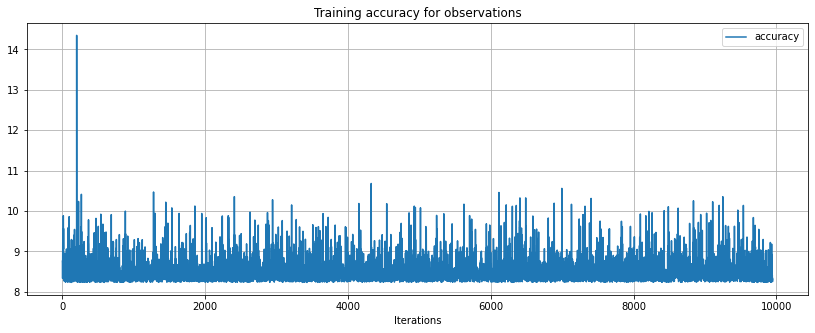

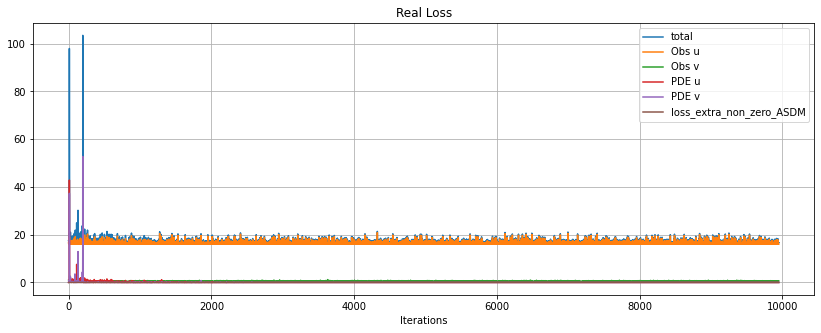

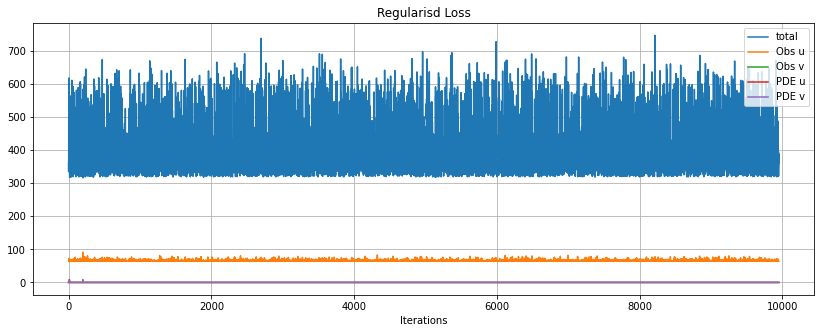

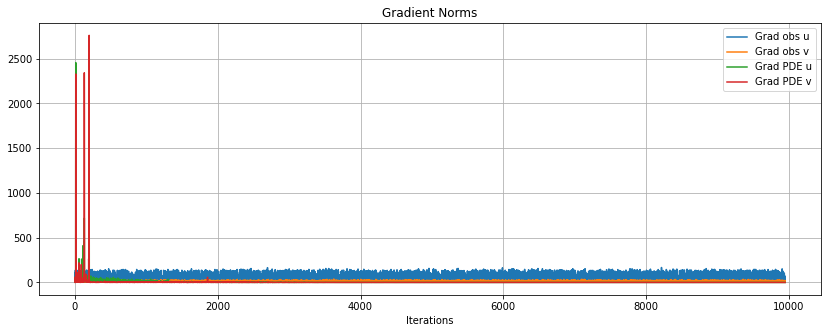

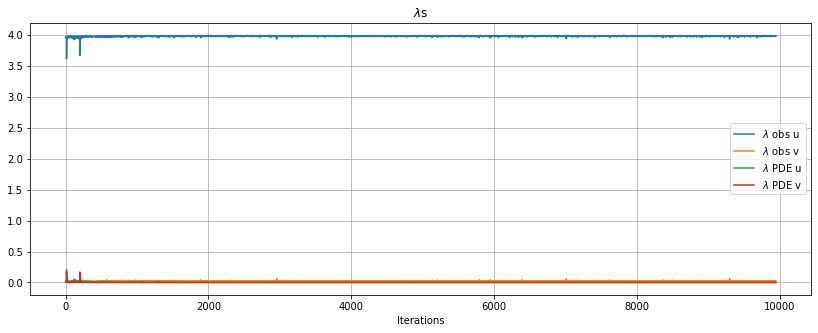

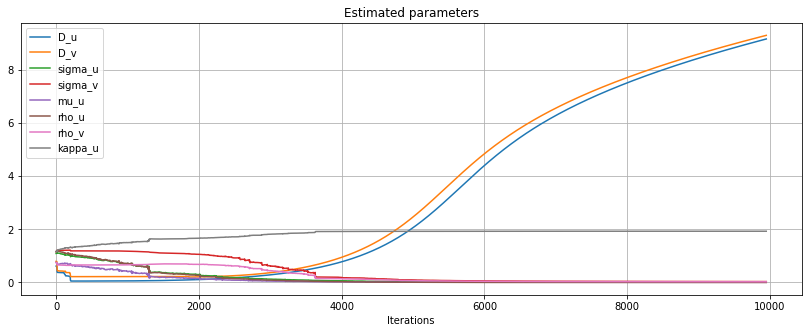

In [11]:
plot_result(merge_dict(results),
            param_names=pde_loss.parameter_names(),  
            start=50,
            yscale = 'linear')

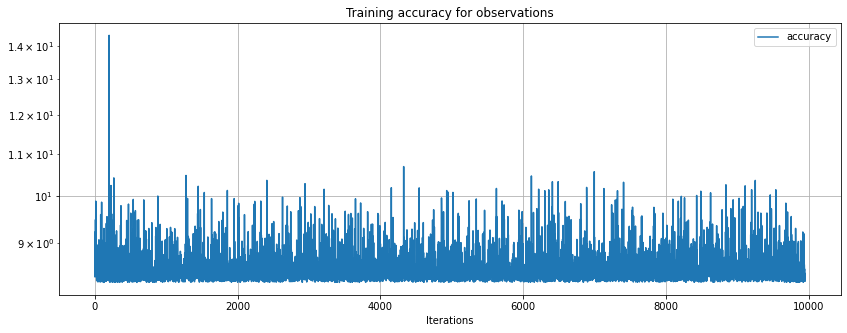

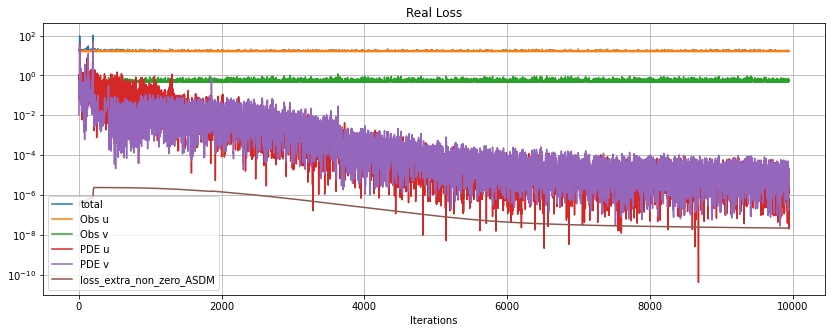

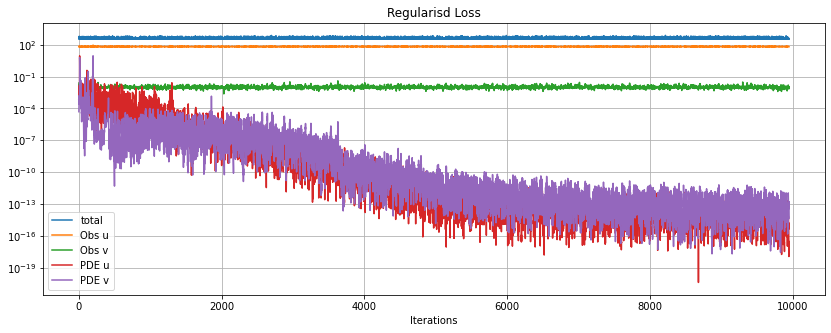

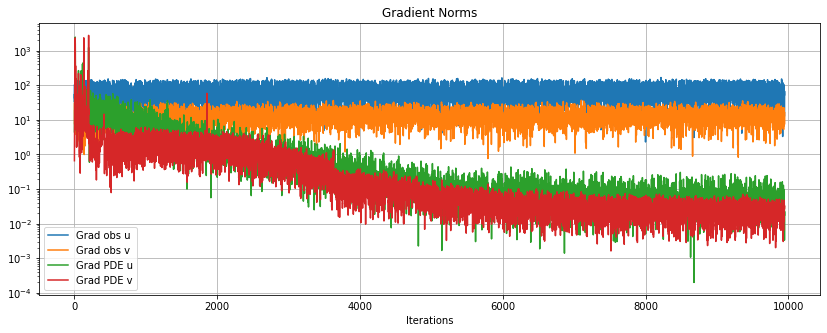

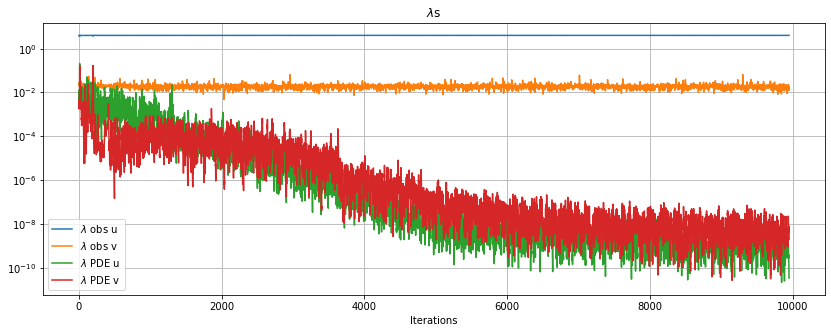

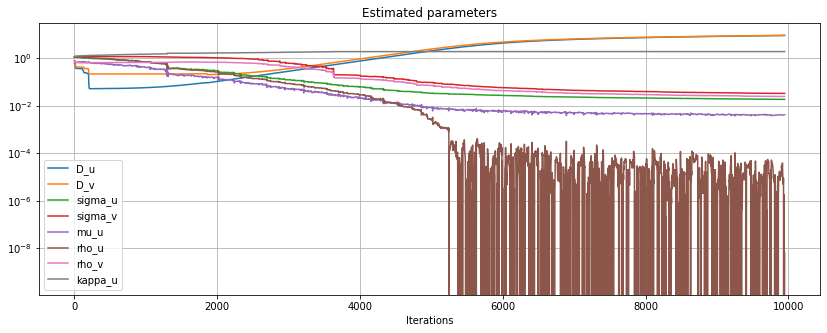

In [12]:
plot_result(merge_dict(results),
            param_names=pde_loss.parameter_names(),  
            start=50,
            yscale = 'log')

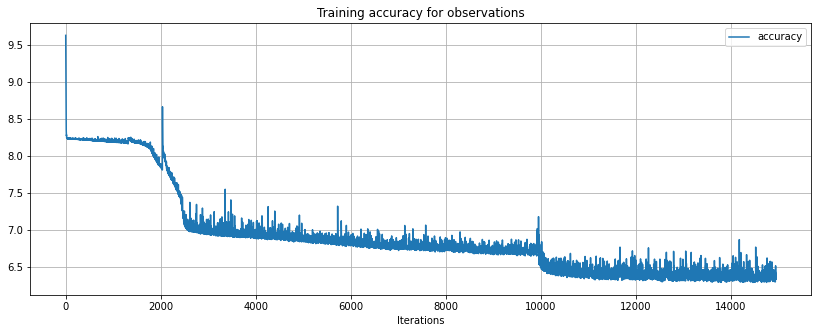

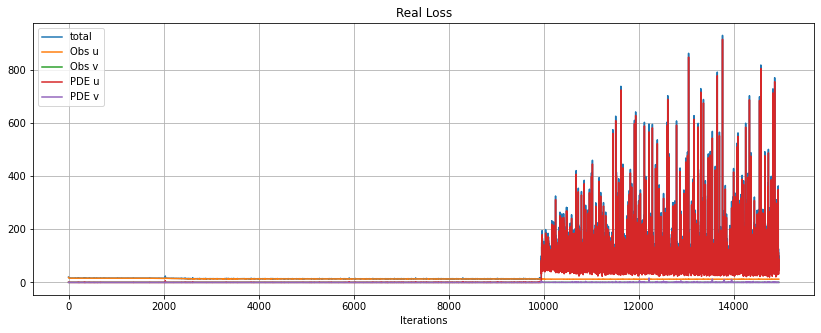

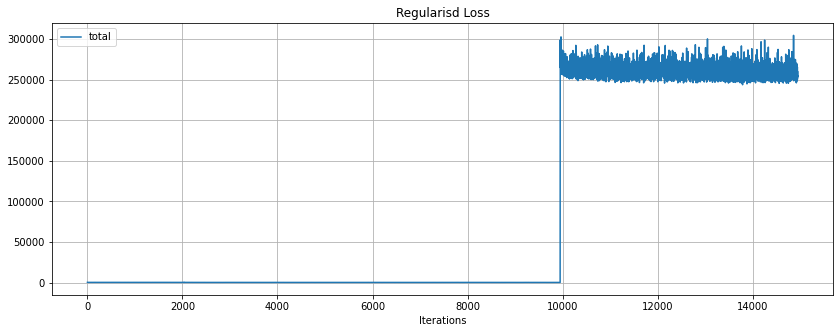

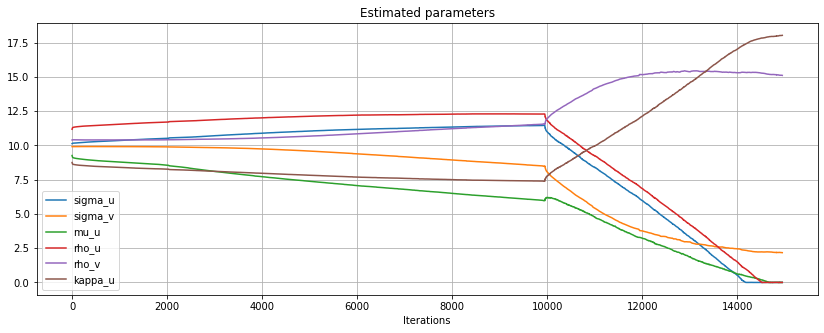

In [19]:
plot_result(merge_dict(results, results2, results3),
            param_names=pde_loss.parameter_names(),  
            start=50,
            yscale = 'linear')

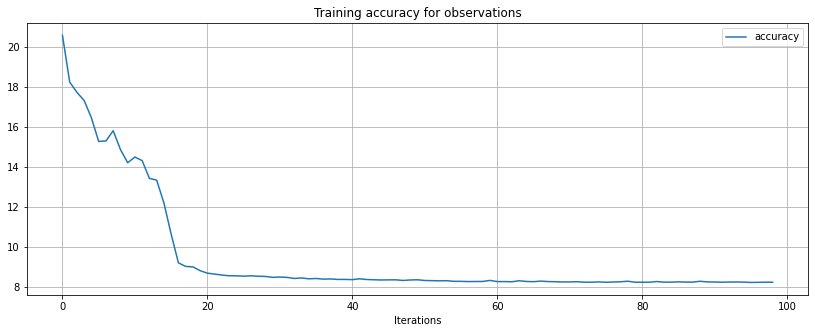

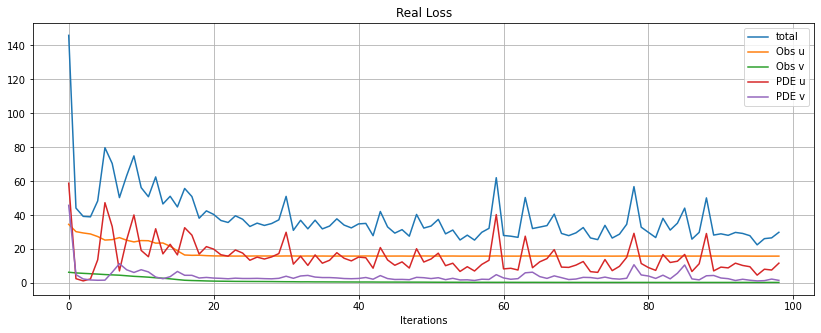

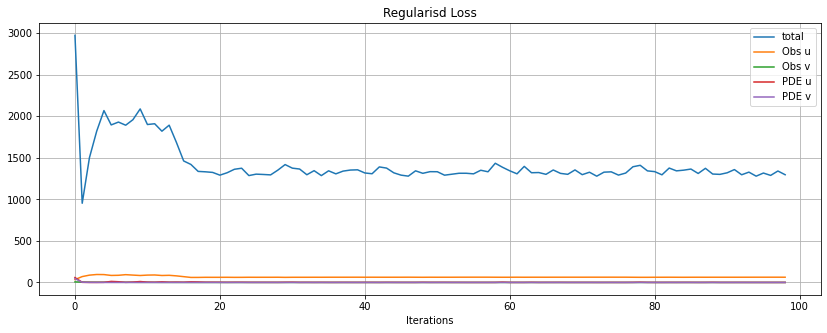

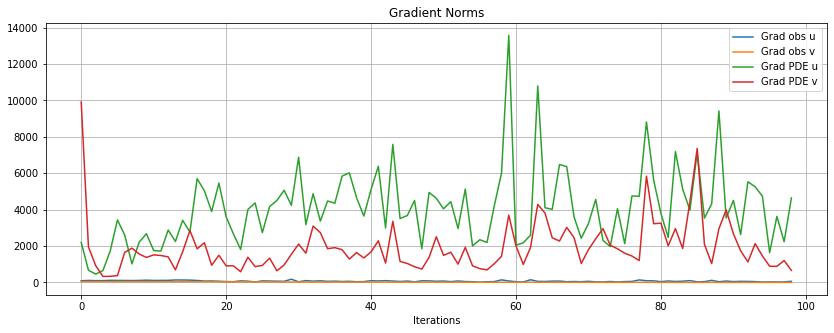

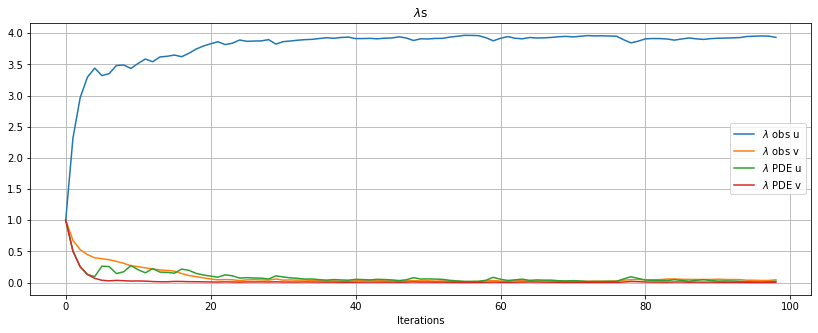

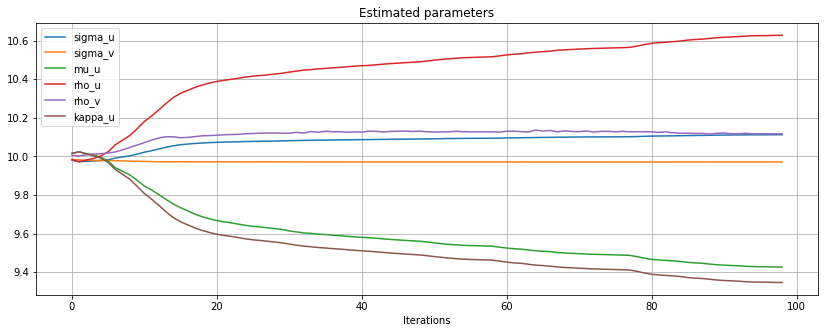

In [6]:
plot_result(results, 
            param_names=pde_loss.parameter_names(),  
            yscale = 'linear')

In [13]:
print(pde_loss.trainables_str())

D_u: 34.70154 D_v: 34.69513 sigma_u: 0.27303 sigma_v: 0.00735 
mu_u: 0.05954 rho_u: 0.05700 rho_v: 2.28225 kappa_u: 651.12068 

